# Introduction to `mleko` with Titanic

This notebook is a quick introduction to `mleko` package. We will use the Titanic dataset to predict whether a passenger survived or not.

The library provides 2 subpackages needed for data processing and model training:

- `dataset`: Subpackage for handling and processing datasets.
  - `ingest`: Module for ingesting (loading) data from various sources.
    - `BaseIngester`: Base class for all ingesters.
    - `KaggleIngester`: Ingests data from Kaggle.
    - `S3Ingester`: Ingests data from Amazon S3.
  - `convert`: Module for converting data into different formats.
    - `BaseConverter`: Base class for all converters.
    - `CsvToVaexConverter`: Converts CSV data into a Vaex DataFrame.
  - `filter`: Module for filtering datasets.
    - `BaseFilter`: Base class for all filters.
    - `ExpressionFilter`: Filters data based on a given expression.
    - `ImblearnSamplingFilter`: Resamples data using `imbalanced-learn`.
  - `split`: Module for splitting datasets into training and testing sets.
    - `BaseSplitter`: Base class for all splitters.
    - `RandomSplitter`: Splits data randomly.
    - `ExpressionSplitter`: Splits data based on a given expression.
  - `transform`: Module for transforming datasets.
    - `BaseTransformer`: Base class for all transformers.
    - `CompositeTransformer`: Combines multiple transformers.
    - `FrequencyEncoderTransformer`: Encodes categorical variables based on their frequency.
    - `LabelEncoderTransformer`: Encodes categorical variables with unique labels.
    - `MaxAbsScalerTransformer`: Scales each feature by its maximum absolute value.
    - `MinMaxScalerTransformer`: Scales each feature to a given range.
  - `feature_select`: Module for feature selection.
    - `BaseFeatureSelector`: Base class for all feature selectors.
    - `CompositeFeatureSelector`: Combines multiple feature selectors.
    - `InvarianceFeatureSelector`: Selects features based on their invariance.
    - `MissingRateFeatureSelector`: Selects features based on their missing rate.
    - `PearsonCorrelationFeatureSelector`: Selects features based on their Pearson correlation.
    - `VarianceFeatureSelector`: Selects features based on their variance.
- `model`: Subpackage for building and training models.
  - `BaseModel`: Base class for all models.
  - `LGBMModel`: Trains a LightGBM model.


# Configuration

This section contains configurations for the notebook.


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

## Constants

Define various constants that will be used throughout the notebook.


In [3]:
# Kaggle dataset identifier
OWNER_SLUG = "yasserh"
DATASET_SLUG = "titanic-dataset"
DATASET_NAME = f"{OWNER_SLUG}/{DATASET_SLUG}"

# Define meta features of the dataset not used as model inputs
TARGET_FEATURE = "Survived"
ID_COLUMN = "PassengerId"
META_FEATURES = [ID_COLUMN, TARGET_FEATURE]

# General Configuration
RANDOM_STATE = 1337

# Download Data

In this cell, we use the `KaggleIngester` from the `mleko` library to download the Titanic dataset from Kaggle.


In [4]:
from mleko.dataset.ingest import KaggleIngester


# Fetch data from Kaggle and return paths to the downloaded files
csv_paths = KaggleIngester(owner_slug=OWNER_SLUG, dataset_slug=DATASET_SLUG).fetch_data()

[2024-03-28 16:06:48] [INFO] Attempting to fetch Kaggle API credentials from environment variables 'KAGGLE_USERNAME' and 'KAGGLE_KEY'. (kaggle_ingester.py:76)
[2024-03-28 16:06:48] [INFO] Kaggle API credentials not found in environment variables, attempting to fetch from fallback path at ~/.kaggle/kaggle.json. (kaggle_ingester.py:84)
[2024-03-28 16:06:48] [INFO] Kaggle credentials successfully fetched. (kaggle_ingester.py:93)
[2024-03-28 16:06:49] [INFO] Found 1 file(s) matching any of ['*'] in Kaggle dataset. (kaggle_ingester.py:377)
[2024-03-28 16:06:49] [INFO] Cache Hit: Local dataset is up to date with Kaggle, skipping download. (kaggle_ingester.py:296)


## Fetching Data from S3

In addition to the `KaggleIngester`, `mleko` also provides the `S3Ingester` for downloading datasets from Amazon S3.

Here's an example of how you can use it:

```python
from mleko.dataset.ingest import S3Ingester

csv_paths = S3Ingester(
    s3_bucket_name="mleko-datasets",
    s3_key_prefix="kaggle/nehaprabhavalkar/indian-food-101",
    aws_profile_name="mleko",
    aws_region_name="eu-west-1",
    num_workers=64,  # Number of workers to use for downloading files.
    check_s3_timestamps=True,  # Ensure that all files are from the same date.
).fetch_data()
```


# Clean Data

Here, we use the `CSVToVaexConverter` from `mleko` to clean the data.

The converter reads the CSV file, drops unnecessary columns, handles missing values, and converts the data into a Vaex DataFrame for efficient processing.


In [5]:
from mleko.dataset.convert import CSVToVaexConverter


clean_schema, clean_df = CSVToVaexConverter(
    drop_columns=["Ticket"],
    meta_columns=META_FEATURES,
    drop_rows_with_na_columns=[TARGET_FEATURE],  # Drop rows with missing target values
    random_state=RANDOM_STATE,  # We like reproducibility
).convert(csv_paths)

[2024-03-28 16:06:51] [INFO] Cache Hit (LRUCache) CSVToVaexConverter.convert: Using cached output. (cache_mixin.py:163)


Investigate the data to see what columns are available and what their data types are.


In [6]:
clean_schema.features

{'numerical': ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp'],
 'categorical': ['Cabin', 'Embarked', 'Name', 'Sex'],
 'boolean': [],
 'datetime': [],
 'timedelta': []}

In [7]:
clean_df.head(10)

#,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,--,S
1,2,1,1,"'Cumings, Mrs. John Bradley (Florence Briggs Tha...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.925,--,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.05,--,S
5,6,0,3,"Moran, Mr. James",male,--,0,0,8.4583,--,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.075,--,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,--,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,--,C


# Split Train/Val and Test Dataset

In this section, we split the cleaned data into a training/validation set and a test set.

We use the `RandomSplitter` from `mleko` to perform a stratified random split, ensuring that both sets have the same proportion of class labels.


In [8]:
from mleko.dataset.split import RandomSplitter


clean_train_val_df, clean_test_df = RandomSplitter(
    data_split=(0.90, 0.10),  # 90% train/val, 10% test
    shuffle=True,  # Shuffle the data before splitting
    stratify=TARGET_FEATURE,  # Stratify on the target feature
    random_state=RANDOM_STATE,  # We like reproducibility
).split(clean_df)

[2024-03-28 16:06:52] [INFO] Cache Hit (LRUCache) RandomSplitter.split: Using cached output. (cache_mixin.py:163)


Ensure the class balance is maintained in the train/val and test sets.


In [9]:
def print_split_stats(df, split_name):
    total_count = df.shape[0]
    survival_count = df[TARGET_FEATURE].sum()  # type: ignore
    survival_rate = survival_count / total_count

    print(f"{split_name}: {survival_rate * 100:.3f}% (Survived: {survival_count:3d}, Total: {total_count:3d})")


print_split_stats(clean_train_val_df, "Train/Val")
print_split_stats(clean_test_df, "Test")

Train/Val: 38.327% (Survived: 307, Total: 801)
Test: 38.889% (Survived:  35, Total:  90)


## Splitting Based on Boolean Expressions

For more complex splits, you can use the `ExpressionSplitter` from `mleko` to split the data based on a given boolean expression.

It is suitable for splitting data based on time, location, or any other condition like the one below:

```python
from mleko.dataset.split import ExpressionSplitter

train_val_df, test_df = ExpressionSplitter(
    expression="(Embarked == 'S') | ((Embarked == 'C') & (Fare < 50))"  # Train/val set contains passengers who embarked from Southampton or Cherbourg and paid less than 50.
).split(filtered_df)
```


# Feature Engineering & Transformation

In this section, we perform feature engineering and transformation using custom transformers, predefined transformers and combining them inside a `CompositeTransformer` from `mleko`.


In [10]:
clean_train_val_df

#,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,--,S
1,2,1,1,"'Cumings, Mrs. John Bradley (Florence Briggs Tha...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.925,--,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.05,--,S
...,...,...,...,...,...,...,...,...,...,...,...
796,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,7.05,--,S
797,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,29.125,--,Q
798,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0,--,S
799,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0,B42,S


## Custom Transformers

It is important the the ML pipeline is flexible and allows for easy experimentation, be it with different feature engineering techniques or different models.

In many cases, the classes provided by `mleko` will be sufficient for your needs. However, you can also create your own custom classes by inheriting from the `BaseClass` class. For transformers, you need to inherit from the `BaseTransformer` class and implement the `__init__`, `_fit`, `_transform`, and `_fingerprint` methods.


In [11]:
from __future__ import annotations

from pathlib import Path
from typing import Hashable

import vaex
import vaex.ml

from mleko.dataset import DataSchema
from mleko.dataset.transform import BaseTransformer
from mleko.utils import auto_repr


class IsAloneTransformer(BaseTransformer):
    @auto_repr
    def __init__(
        self,
        cache_directory: str | Path = "data/is-alone-transformer",
        cache_size: int = 1,
    ) -> None:
        super().__init__([], cache_directory, cache_size)
        self._transformer = -1

    def _fit(self, data_schema: DataSchema, _dataframe: vaex.DataFrame) -> tuple[DataSchema, int]:
        """No fitting required for this transformer."""
        ds = data_schema.copy().add_feature("IsAlone", "boolean")
        return ds, self._transformer

    def _transform(self, data_schema: DataSchema, dataframe: vaex.DataFrame) -> tuple[DataSchema, vaex.DataFrame]:
        """Add a new feature to the dataset indicating whether the passenger was alone or not."""
        df = dataframe.copy()
        df["IsAlone"] = (df["SibSp"] + df["Parch"] == 0).astype("int8")
        ds = data_schema.copy().add_feature("IsAlone", "boolean")
        return ds, df

    def _fingerprint(self) -> Hashable:
        return super()._fingerprint()


class FeatureDropperTransformer(BaseTransformer):
    @auto_repr
    def __init__(
        self,
        features: list[str] | tuple[str, ...],
        cache_directory: str | Path = "data/feature-dropper-transformer",
        cache_size: int = 1,
    ) -> None:
        super().__init__(features, cache_directory, cache_size)
        self._transformer = -1

    def _fit(self, data_schema: DataSchema, _dataframe: vaex.DataFrame) -> tuple[DataSchema, int]:
        """No fitting required for this transformer."""
        ds = data_schema.copy().drop_features(self._features)
        return ds, self._transformer

    def _transform(self, data_schema: DataSchema, dataframe: vaex.DataFrame) -> tuple[DataSchema, vaex.DataFrame]:
        """Drop the specified features from the dataset."""
        df = dataframe.drop(self._features, inplace=False)
        ds = data_schema.copy().drop_features(self._features)
        return ds, df

    def _fingerprint(self) -> Hashable:
        return super()._fingerprint()

Transformers can be applied individually or combined into a `CompositeTransformer`. The `CompositeTransformer` allows you to combine multiple transformers into a single transformer, saving you from having to apply each transformer individually, like a small pipeline. The custom transformers can be used in the same way as the predefined ones, e.g. `LabelEncoderTransformer` or `FrequencyEncoderTransformer`.

The transformers follows the common `fit` and `transform` pattern, similar to `scikit-learn`. This is true for feature selectors and models as well.


In [12]:
from mleko.dataset.transform import CompositeTransformer, LabelEncoderTransformer


composite_transformer = CompositeTransformer(
    transformers=[
        FeatureDropperTransformer(features=["Name"]),
        IsAloneTransformer(),
        LabelEncoderTransformer(features=["Sex", "Embarked"]),
    ],
)

transform_schema, _, transform_train_val_df = composite_transformer.fit_transform(clean_schema, clean_train_val_df)
_, transform_test_df = composite_transformer.transform(clean_schema, clean_test_df)

[2024-03-28 16:06:54] [WARNING] Null values will be kept as `None`. (label_encoder_transformer.py:119)
[2024-03-28 16:06:54] [INFO] Cache Hit (LRUCache) CompositeTransformer.fit_transform: Using cached output. (cache_mixin.py:163)
[2024-03-28 16:06:54] [INFO] Cache Hit (LRUCache) CompositeTransformer.transform: Using cached output. (cache_mixin.py:163)


Ensure the transformed dataset has correct data types.


In [13]:
transform_schema.features

{'numerical': ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp'],
 'categorical': ['Cabin', 'Embarked', 'Sex'],
 'boolean': ['IsAlone'],
 'datetime': [],
 'timedelta': []}

In [14]:
transform_train_val_df

#,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,IsAlone
0,1,0,3,1,22.0,1,0,7.25,--,2,0
1,2,1,1,0,38.0,1,0,71.2833,C85,1,0
2,3,1,3,0,26.0,0,0,7.925,--,2,1
3,4,1,1,0,35.0,1,0,53.1,C123,2,0
4,5,0,3,1,35.0,0,0,8.05,--,2,1
...,...,...,...,...,...,...,...,...,...,...,...
796,885,0,3,1,25.0,0,0,7.05,--,2,1
797,886,0,3,0,39.0,0,5,29.125,--,0,0
798,887,0,2,1,27.0,0,0,13.0,--,2,1
799,888,1,1,0,19.0,0,0,30.0,B42,2,1


# Feature Selection

Here, we use the `CompositeFeatureSelector` from `mleko` to select the most relevant features for our model. We use three selectors: `MissingRateFeatureSelector` to remove features with too many missing values, `InvarianceFeatureSelector` to remove invariant features, and `PearsonCorrelationFeatureSelector` to remove highly correlated features. We also display a correlation matrix for the selected numerical features.

Just like transformers, feature selectors can be applied individually or combined into a `CompositeFeatureSelector`, and allow for custom feature selectors.


In [15]:
from mleko.dataset.feature_select import (
    CompositeFeatureSelector,
    InvarianceFeatureSelector,
    MissingRateFeatureSelector,
    PearsonCorrelationFeatureSelector,
)


composite_feature_selector = CompositeFeatureSelector(
    feature_selectors=[
        MissingRateFeatureSelector(
            missing_rate_threshold=0.5,
            ignore_features=META_FEATURES,
        ),
        InvarianceFeatureSelector(
            ignore_features=META_FEATURES,
        ),
        PearsonCorrelationFeatureSelector(
            correlation_threshold=0.7,
            ignore_features=META_FEATURES,
        ),
    ],
)

data_schema, _, feature_select_train_val_df = composite_feature_selector.fit_transform(
    transform_schema, transform_train_val_df
)
_, test_df = composite_feature_selector.transform(transform_schema, transform_test_df)

[2024-03-28 16:06:56] [INFO] Cache Hit (LRUCache) CompositeFeatureSelector.fit_transform: Using cached output. (cache_mixin.py:163)
[2024-03-28 16:06:56] [INFO] Cache Hit (LRUCache) CompositeFeatureSelector.transform: Using cached output. (cache_mixin.py:163)


The `Cabin` feature has too many missing values, so we drop it. No other feature was dropped.


In [16]:
data_schema.features

{'numerical': ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp'],
 'categorical': ['Embarked', 'Sex'],
 'boolean': ['IsAlone'],
 'datetime': [],
 'timedelta': []}

In [17]:
feature_select_train_val_df

#,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone
0,1,0,3,1,22.0,1,0,7.25,2,0
1,2,1,1,0,38.0,1,0,71.2833,1,0
2,3,1,3,0,26.0,0,0,7.925,2,1
3,4,1,1,0,35.0,1,0,53.1,2,0
4,5,0,3,1,35.0,0,0,8.05,2,1
...,...,...,...,...,...,...,...,...,...,...
796,885,0,3,1,25.0,0,0,7.05,2,1
797,886,0,3,0,39.0,0,5,29.125,0,0
798,887,0,2,1,27.0,0,0,13.0,2,1
799,888,1,1,0,19.0,0,0,30.0,2,1


# Hyperparameter Tuning

The `mleko` library provides a `OptunaTuner` class for hyperparameter tuning. Here we use it to tune the hyperparameters of the `LGBMModel` model using 5-fold cross-validation, and measuring the performance using the `average_precision` metric. Each trial is run for 50 iterations, and we run 100 trials in total.


In [23]:
import logging
from statistics import mean

import lightgbm as lgb
import optuna
from imblearn.over_sampling import RandomOverSampler

from mleko.dataset.filter.imblearn_resampling_filter import ImblearnResamplingFilter
from mleko.model import LGBMModel
from mleko.model.tune import OptunaTuner


def cv_folds(data_schema: DataSchema, dataframe: vaex.DataFrame) -> list[tuple[vaex.DataFrame, vaex.DataFrame]]:
    cv_datasets = []
    splits = dataframe.split_random(into=5, random_state=RANDOM_STATE)
    for i, validation_df in enumerate(splits):
        train_df = vaex.concat([df for j, df in enumerate(splits) if j != i])
        resampled_train_df = ImblearnResamplingFilter(RandomOverSampler(), TARGET_FEATURE).filter(
            data_schema, train_df, disable_cache=True
        )
        cv_datasets.append((resampled_train_df, validation_df))

    return cv_datasets


def objective(
    trial: optuna.Trial, data_schema: DataSchema, cv_dataframes: list[tuple[vaex.DataFrame, vaex.DataFrame]]
) -> float:
    lgbm_model = LGBMModel(
        target=TARGET_FEATURE,
        model=lgb.LGBMClassifier(objective="binary", n_estimators=30),
        eval_metric=["average_precision", "auc"],
        ignore_features=META_FEATURES,
        random_state=RANDOM_STATE,
        verbosity=logging.CRITICAL,
    )

    lambda_l1 = trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True)
    lambda_l2 = trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True)
    num_leaves = trial.suggest_int("num_leaves", 2, 1024)
    max_depth = trial.suggest_int("max_depth", 1, 40)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_child_weight = trial.suggest_float("min_child_weight", 1e-5, 1e-2, log=True)
    feature_fraction = trial.suggest_float("feature_fraction", 0.4, 1.0)
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.4, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 1, 7)
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1.0, log=True)

    hyperparameters = {
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "num_leaves": num_leaves,
        "max_depth": max_depth,
        "min_child_samples": min_child_samples,
        "min_child_weight": min_child_weight,
        "feature_fraction": feature_fraction,
        "bagging_fraction": bagging_fraction,
        "bagging_freq": bagging_freq,
        "learning_rate": learning_rate,
    }

    scores: list[float] = []
    for train_df, validation_df in cv_dataframes:
        _, metrics, _, _ = lgbm_model.fit_transform(
            data_schema, train_df, validation_df, hyperparameters, disable_cache=True
        )
        scores.append(metrics["validation"]["average_precision"][-1])

    return mean(scores)


hyperparameters, best_score, study = OptunaTuner(
    objective_function=objective,
    cv_folds=cv_folds,
    direction="maximize",
    num_trials=250,
    random_state=RANDOM_STATE,
).tune(data_schema, feature_select_train_val_df)

[2024-03-28 16:09:16] [INFO] Cache Miss (LRUCache) OptunaTuner.tune: Executing method. (cache_mixin.py:168)
[2024-03-28 16:09:16] [INFO] A new study created in memory with name: 2024-03-28 16:09:16 (_in_memory.py:70)


  0%|          | 0/250 [00:00<?, ?it/s]

[2024-03-28 16:09:16] [INFO] Imblearn resampling DataFrame using 'RandomOverSampler'. (imblearn_resampling_filter.py:122)
[2024-03-28 16:09:16] [INFO] Ensuring that the resampled DataFrame handles NaN values correctly. (imblearn_resampling_filter.py:136)
[2024-03-28 16:09:16] [INFO] Setting the 'Synthetic' column to 1 for the synthetic samples. (imblearn_resampling_filter.py:145)
[2024-03-28 16:09:16] [INFO] Generated 134 synthetic samples. (imblearn_resampling_filter.py:149)
[2024-03-28 16:09:16] [INFO] Imblearn resampling DataFrame using 'RandomOverSampler'. (imblearn_resampling_filter.py:122)
[2024-03-28 16:09:16] [INFO] Ensuring that the resampled DataFrame handles NaN values correctly. (imblearn_resampling_filter.py:136)
[2024-03-28 16:09:17] [INFO] Setting the 'Synthetic' column to 1 for the synthetic samples. (imblearn_resampling_filter.py:145)
[2024-03-28 16:09:17] [INFO] Generated 150 synthetic samples. (imblearn_resampling_filter.py:149)
[2024-03-28 16:09:17] [INFO] Imblearn 

In [28]:
hyperparameters

{'lambda_l1': 1.2987066339452e-05,
 'lambda_l2': 0.00031450963445684436,
 'num_leaves': 345,
 'max_depth': 21,
 'min_child_samples': 26,
 'min_child_weight': 0.00046667769867157576,
 'feature_fraction': 0.7844801037880264,
 'bagging_fraction': 0.7030248291818879,
 'bagging_freq': 3,
 'learning_rate': 0.158746126869997}

In [29]:
best_score

0.8512611869044004

# Train Model

We further split our training/validation data into a training set and a validation set. The `LGBMModel` is trained on the training set and evaluated on the validation set.


In [30]:
train_df, val_df = RandomSplitter(
    data_split=(0.80, 0.20),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
).split(feature_select_train_val_df, cache_group="train_val")

[2024-03-28 16:11:07] [INFO] Cache Hit (LRUCache) RandomSplitter.split: Using cached output. (cache_mixin.py:163)


# Filter Dataset

In this step, we will randomly over-sample the dataset using the `ImblearnSamplingFilter`.


In [31]:
resampled_train_df = ImblearnResamplingFilter(RandomOverSampler(), TARGET_FEATURE).filter(data_schema, train_df)

[2024-03-28 16:11:09] [INFO] Cache Hit (LRUCache) ImblearnResamplingFilter.filter: Using cached output. (cache_mixin.py:163)


Ensure the class balance is maintained in the training, validation and test sets.


In [32]:
print_split_stats(resampled_train_df, "Train")
print_split_stats(val_df, "Val")
print_split_stats(test_df, "Test")

Train: 50.000% (Survived: 395, Total: 790)
Val: 38.509% (Survived:  62, Total: 161)
Test: 38.889% (Survived:  35, Total:  90)


In [33]:
hyperparameters

{'lambda_l1': 1.2987066339452e-05,
 'lambda_l2': 0.00031450963445684436,
 'num_leaves': 345,
 'max_depth': 21,
 'min_child_samples': 26,
 'min_child_weight': 0.00046667769867157576,
 'feature_fraction': 0.7844801037880264,
 'bagging_fraction': 0.7030248291818879,
 'bagging_freq': 3,
 'learning_rate': 0.158746126869997}

Train the model and evaluate it on the validation set.


In [39]:
lgbm_model = LGBMModel(
    target=TARGET_FEATURE,
    model=lgb.LGBMClassifier(objective="binary", n_estimators=75),
    eval_metric=["average_precision", "auc"],
    ignore_features=META_FEATURES,
    random_state=RANDOM_STATE,
)

model, metrics, p_train_df, p_val_df = lgbm_model.fit_transform(
    data_schema, resampled_train_df, val_df, hyperparameters=hyperparameters
)

[2024-03-28 16:12:24] [INFO] Cache Hit (LRUCache) LGBMModel.fit_transform: Using cached output. (cache_mixin.py:163)


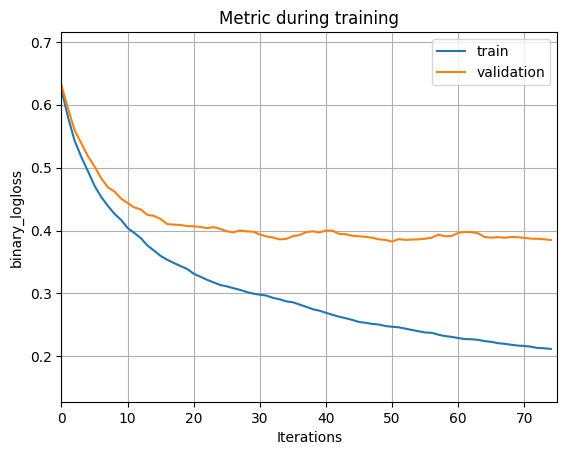

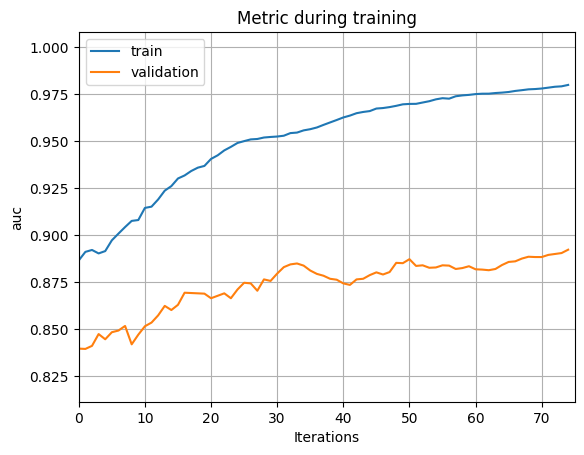

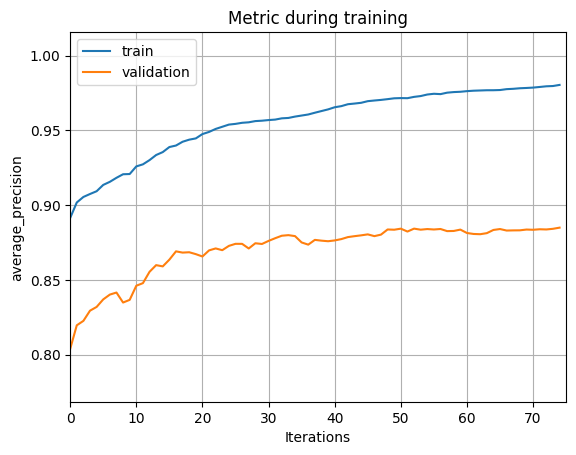

In [40]:
ax = lgb.plot_metric(metrics, metric="binary_logloss")
ax = lgb.plot_metric(metrics, metric="auc")
ax = lgb.plot_metric(metrics, metric="average_precision")

# `mleko` Pipeline

The `mleko` pipeline is used to streamline the entire process. Pipelines are very flexible and allows users to define a directed acyclic graph (DAG) of operations. You can chain together all operations in a single pipeline or create multiple pipelines for different tasks.

We create two pipelines:

- a pre-processing pipeline that handles data ingestion, conversion, splitting, transformation, and feature selection
- a model pipeline that trains and evaluates the model.

Next we define all required classes to create the pre-processing pipeline.


In [41]:
!rm -r data

## Pre-Processing Pipeline


In [42]:
kaggle_ingester = KaggleIngester(owner_slug=OWNER_SLUG, dataset_slug=DATASET_SLUG)

[2024-03-28 16:12:40] [INFO] Attempting to fetch Kaggle API credentials from environment variables 'KAGGLE_USERNAME' and 'KAGGLE_KEY'. (kaggle_ingester.py:76)
[2024-03-28 16:12:40] [INFO] Kaggle API credentials not found in environment variables, attempting to fetch from fallback path at ~/.kaggle/kaggle.json. (kaggle_ingester.py:84)
[2024-03-28 16:12:40] [INFO] Kaggle credentials successfully fetched. (kaggle_ingester.py:93)


In [43]:
csv_to_vaex_converter = CSVToVaexConverter(
    drop_columns=["Ticket"],
    meta_columns=META_FEATURES,
    drop_rows_with_na_columns=[TARGET_FEATURE],
    random_state=RANDOM_STATE,
)

In [44]:
random_splitter_90_10 = RandomSplitter(
    data_split=(0.90, 0.10),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
)

In [45]:
composite_transformer = CompositeTransformer(
    transformers=[
        FeatureDropperTransformer(features=["Name"]),
        IsAloneTransformer(),
        LabelEncoderTransformer(features=["Sex", "Embarked"]),
    ],
)

[2024-03-28 16:12:46] [WARNING] Null values will be kept as `None`. (label_encoder_transformer.py:119)


In [46]:
composite_feature_selector = CompositeFeatureSelector(
    feature_selectors=[
        MissingRateFeatureSelector(
            missing_rate_threshold=0.5,
            ignore_features=META_FEATURES,
        ),
        InvarianceFeatureSelector(
            ignore_features=META_FEATURES,
        ),
        PearsonCorrelationFeatureSelector(
            correlation_threshold=0.7,
            ignore_features=META_FEATURES,
        ),
    ],
)

In [47]:
random_splitter_80_20 = RandomSplitter(
    data_split=(0.80, 0.20),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
)

In [48]:
resampler = ImblearnResamplingFilter(RandomOverSampler(), TARGET_FEATURE)

Define the pre-processing pipeline performing all the dataset pre-processing steps before training the model.

Each `PipelineStep` accepts a class, a list of input names, and a list of output names. The class is used to instantiate the step, the input names are used to fetch the required data from the previous steps, and the output names are used to store the output of the step for use by subsequent steps.


In [49]:
from mleko.pipeline import Pipeline
from mleko.pipeline.steps import ConvertStep, FeatureSelectStep, IngestStep, SplitStep, TransformStep, FilterStep


pre_pipeline = Pipeline(
    steps=[
        IngestStep(kaggle_ingester, inputs={}, outputs={"file_paths": "raw_csv"}),
        ConvertStep(
            csv_to_vaex_converter,
            inputs={"file_paths": "raw_csv"},
            outputs={"data_schema": "clean_data_schema", "dataframe": "clean_df"},
        ),
        SplitStep(
            random_splitter_90_10,
            inputs={"dataframe": "clean_df"},
            outputs={"dataframe_1": "train_val_df", "dataframe_2": "test_df"},
            cache_group="train_val_test",
        ),
        TransformStep(
            composite_transformer,
            action="fit_transform",
            inputs={"data_schema": "clean_data_schema", "dataframe": "train_val_df"},
            outputs={
                "data_schema": "transform_data_schema",
                "dataframe": "transform_train_val_df",
                "transformer": "composite_transformer",
            },
            cache_group="train_val",
        ),
        TransformStep(
            composite_transformer,
            action="transform",
            inputs={"data_schema": "clean_data_schema", "dataframe": "test_df"},
            outputs={
                "data_schema": "transform_data_schema",
                "dataframe": "transform_test_df",
            },
            cache_group="test",
        ),
        FeatureSelectStep(
            composite_feature_selector,
            action="fit_transform",
            inputs={"data_schema": "transform_data_schema", "dataframe": "transform_train_val_df"},
            outputs={
                "data_schema": "data_schema",
                "dataframe": "selected_train_val_df",
                "feature_selector": "composite_feature_selector",
            },
            cache_group="train_val",
        ),
        FeatureSelectStep(
            composite_feature_selector,
            action="transform",
            inputs={"data_schema": "transform_data_schema", "dataframe": "transform_test_df"},
            outputs={"data_schema": "data_schema", "dataframe": "test_df"},
            cache_group="test",
        ),
        SplitStep(
            random_splitter_80_20,
            inputs={"dataframe": "selected_train_val_df"},
            outputs={"dataframe_1": "train_df", "dataframe_2": "val_df"},
            cache_group="train_val",
        ),
        FilterStep(
            resampler,
            inputs={"data_schema": "data_schema", "dataframe": "train_df"},
            outputs={"dataframe": "resampled_train_df"},
        ),
    ]
)

Print `Pipeline` steps to see the order in which they will be executed, for double-checking.


In [50]:
pre_pipeline

Pipeline:
  1. IngestStep(ingester=KaggleIngester(file_pattern='*', dataset_id=None, cache_directory='data/kaggle-ingester', dataset_version=None, kaggle_api_credentials_file=None, num_workers=64, owner_slug='yasserh', dataset_slug='titanic-dataset'), inputs={}, outputs={'file_paths': 'raw_csv'})
  2. ConvertStep(converter=CSVToVaexConverter(forced_numerical_columns=(), forced_categorical_columns=(), forced_boolean_columns=(), drop_columns=['Ticket'], meta_columns=['PassengerId', 'Survived'], drop_rows_with_na_columns=['Survived'], na_values=('-9998', '-9998.0', '-9999', '-9999.0', '-99', '-99.0', 'nan', 'none', 'non', 'Nan', 'None', 'Non', '', 'N/A', 'N/a', 'unknown', 'missing'), true_values=('t', 'True', 'true', '1'), false_values=('f', 'False', 'false', '0'), downcast_float=False, random_state=1337, num_workers=12, cache_directory='data/csv-to-vaex-converter', cache_size=1), cache_group=None, inputs={'file_paths': 'raw_csv'}, outputs={'data_schema': 'clean_data_schema', 'dataframe':

Execute the pre-processing pipeline and store the output in `pre_data_container`.


In [52]:
pre_data_container = pre_pipeline.run()

[2024-03-28 16:13:10] [INFO] No data container provided. Creating an empty one. (pipeline.py:78)
[2024-03-28 16:13:10] [INFO] Executing step 1/9: IngestStep. (pipeline.py:82)
[2024-03-28 16:13:10] [INFO] Found 1 file(s) matching any of ['*'] in Kaggle dataset. (kaggle_ingester.py:377)
[2024-03-28 16:13:10] [INFO] Cache Hit: Local dataset is up to date with Kaggle, skipping download. (kaggle_ingester.py:296)
[2024-03-28 16:13:10] [INFO] Finished step 1/9 execution. (pipeline.py:84)
[2024-03-28 16:13:10] [INFO] Executing step 2/9: ConvertStep. (pipeline.py:82)
[2024-03-28 16:13:10] [INFO] Cache Hit (LRUCache) CSVToVaexConverter.convert: Using cached output. (cache_mixin.py:163)
[2024-03-28 16:13:10] [INFO] Finished step 2/9 execution. (pipeline.py:84)
[2024-03-28 16:13:10] [INFO] Executing step 3/9: SplitStep. (pipeline.py:82)
[2024-03-28 16:13:10] [INFO] Cache Hit (LRUCache) RandomSplitter.split: Using cached output. (cache_mixin.py:163)
[2024-03-28 16:13:10] [INFO] Finished step 3/9 ex

## Model Pipeline


In [56]:
optuna_tuner = OptunaTuner(
    objective_function=objective,
    cv_folds=cv_folds,
    direction="maximize",
    num_trials=250,
    random_state=RANDOM_STATE,
)

lgbm_model = LGBMModel(
    target=TARGET_FEATURE,
    model=lgb.LGBMClassifier(objective="binary", n_estimators=75),
    eval_metric=["average_precision", "auc"],
    ignore_features=META_FEATURES,
    random_state=RANDOM_STATE,
)

In [57]:
from mleko.pipeline.steps import ModelStep, TuneStep


model_pipeline = Pipeline(
    steps=[
        TuneStep(
            optuna_tuner,
            inputs={"data_schema": "data_schema", "dataframe": "selected_train_val_df"},
            outputs={"hyperparameters": "hyperparameters", "score": "best_tuning_score", "metadata": "optuna_study"},
        ),
        ModelStep(
            lgbm_model,
            action="fit_transform",
            inputs={
                "data_schema": "data_schema",
                "dataframe": "resampled_train_df",
                "validation_dataframe": "val_df",
                "hyperparameters": "hyperparameters",
            },
            outputs={
                "model": "lgbm_model",
                "metrics": "metrics",
                "dataframe": "pred_resampled_train_df",
                "validation_dataframe": "pred_val_df",
            },
        ),
        ModelStep(
            lgbm_model,
            action="transform",
            inputs={"data_schema": "data_schema", "dataframe": "test_df"},
            outputs={"dataframe": "pred_test_df"},
        ),
    ]
)

Run the model pipeline by feeding the output of the pre-processing pipeline into it.


In [59]:
data_container = model_pipeline.run(data_container=pre_data_container)
result = data_container.data

[2024-03-28 16:15:40] [INFO] Executing step 1/3: TuneStep. (pipeline.py:82)
[2024-03-28 16:15:40] [INFO] Cache Hit (LRUCache) OptunaTuner.tune: Using cached output. (cache_mixin.py:163)
[2024-03-28 16:15:40] [INFO] Finished step 1/3 execution. (pipeline.py:84)
[2024-03-28 16:15:40] [INFO] Executing step 2/3: ModelStep. (pipeline.py:82)
[2024-03-28 16:15:40] [INFO] Cache Hit (LRUCache) LGBMModel.fit_transform: Using cached output. (cache_mixin.py:163)
[2024-03-28 16:15:40] [INFO] Finished step 2/3 execution. (pipeline.py:84)
[2024-03-28 16:15:40] [INFO] Executing step 3/3: ModelStep. (pipeline.py:82)
[2024-03-28 16:15:40] [INFO] Cache Hit (LRUCache) LGBMModel.transform: Using cached output. (cache_mixin.py:163)
[2024-03-28 16:15:40] [INFO] Finished step 3/3 execution. (pipeline.py:84)


All results from each step are stored in the `data_container.data` object.


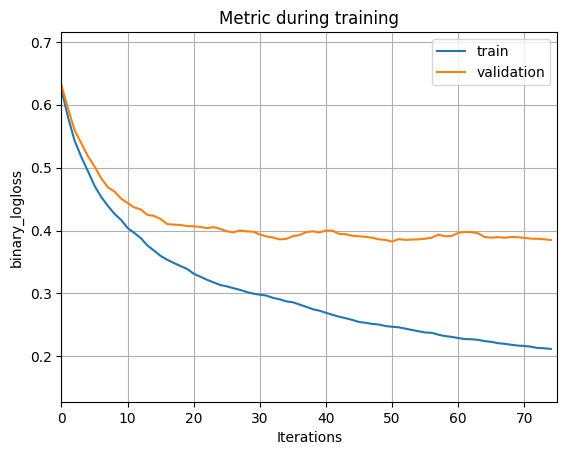

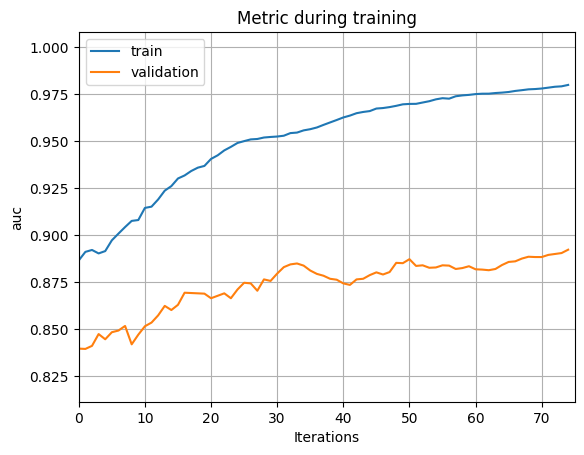

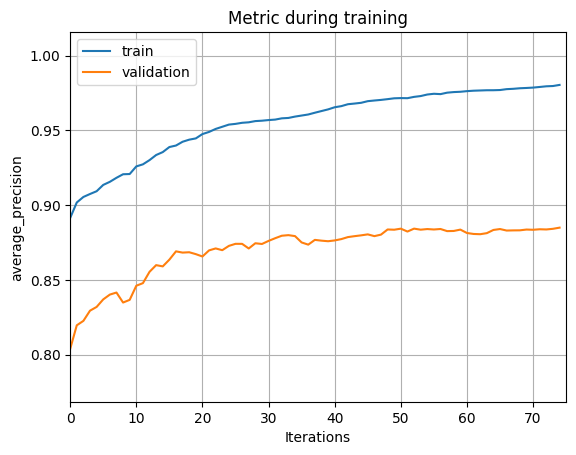

In [60]:
ax = lgb.plot_metric(result["metrics"], metric="binary_logloss")
ax = lgb.plot_metric(result["metrics"], metric="auc")
ax = lgb.plot_metric(result["metrics"], metric="average_precision")